<a href="https://colab.research.google.com/github/ntomasini/cruzityping/blob/main/typingcruzi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

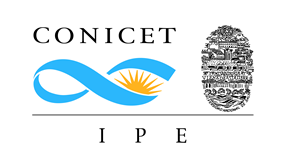

#Colab for Trypanosoma cruzi Typing


---


This notebook is designed for an easy run of bioinformatic steps for Trypanosoma cruzi DTU typing using mHVR amplicon sequencing (see the related publication).

**Steps:**

1. Load ".fastq" or ".fastq.gz" files into a folder in your Google Drive. All ".fastq" or ".fastq.gz" reads in the folder will be analyzed (you should have R1 and R2 files for each sample). Don't use a folder name with spaces, e.g. instead of "my seqs" use "my_seqs".

2. Mount your Google Drive in the Colab at the left panel (click on the folder icon and then on the folder with the Google Drive icon).

**Set Parameters:**

3. Set the "folder" parameter name as the folder in your Google Drive.
4. Set the reference set (85 or 95).
5. Ensure that file names end with the values provided in `filename_end_R1` and `filename_end_R2` for each sample, 

    e.g. if your filename for R1 reads is **sar1006-2022_H1_S9_R1_001.fastq.gz** 

    set 

    `filename_end_R1` = 'R1_001'

    `my_file_type` = '.fastq.gz'

    e.g. if your filename for R2 reads is **sar1007-2023_H1_S9_R1.fastq**

    set 

    `filename_end_R1` = 'R2'

    `my_file_type` = '.fastq'

6. Press Ctrl + F9 to run all cells or run each one at a time by clicking on the play button to the left of each cell.
7. The summary will be printed in the last cell. Additionally, you can find the results in your Google Drive. The results should be in the folder "Typing_Results" within the folder you specified in Google Drive.

Important
If a step was interrupted by colab desconection you can run again:
1. Mount your Google drive  
2. Run 'Set Parameters' cell
3. Run the cells that were not completed



In [ ]:
#@title Mount Google Drive (optative - recommended! If not, when the notebook is disconected you will lost your results)
from google.colab import drive
drive.mount('/content/drive')


In [3]:
#@title Set parameters { form-width: "50%", display-mode: "form" }
folder = "seqs" #@param {type:"string"}
referenceSet = "95" #@param ["95", "85"]
my_file_type = ".fastq" #@param [".fastq", ".fastq.gz"]
filename_end_R1 = "R1_001" #@param {type:"string"}
filename_end_R2 = "R2_001" #@param {type:"string"}
#@markdown gdrive
# Set paths to input and output files

input_dir = '/content/drive/MyDrive/'+ folder 

output_dir = input_dir + '/' + 'trimmo' 
!mkdir {output_dir}
trimmomatic_dir = '/content/Trimmomatic-0.39/'
leehom_dir = '/leeHom/'


mkdir: cannot create directory ‘/content/drive/MyDrive/seqs/trimmo’: File exists


In [ ]:
#@title Trimming
#Getting Trimmomatic
!pip install biopython
!apt-get update
!apt-get install default-jre
!wget http://www.usadellab.org/cms/uploads/supplementary/Trimmomatic/Trimmomatic-0.39.zip
!unzip Trimmomatic-0.39.zip

#run trimmomatic  on folder

import subprocess
import gzip
import shutil
import os

if my_file_type == ".fastq.gz":
  for gz_file in os.listdir(input_dir + '/'):
    if gz_file.endswith('.gz'):
      with gzip.open(os.path.join(input_dir,gz_file) , "rb") as f_in:
                with open(os.path.join(input_dir,gz_file).replace('.gz','') , "wb") as f_out:
                    shutil.copyfileobj(f_in, f_out)

# Loop over all R1 files in input directory
for r1_file in os.listdir(input_dir + '/'):
    
    if r1_file.endswith(filename_end_R1 + '.fastq'):
        
        # Get corresponding R2 file name
        r2_file = r1_file.replace(filename_end_R1 + '.fastq', filename_end_R2 +'.fastq')
       
        # Set paths to input and output files
        r1_path = os.path.join(input_dir, r1_file)
        r2_path = os.path.join(input_dir, r2_file)
        
        
       
        trimmed_r1_path = os.path.join(output_dir, r1_file.replace(filename_end_R1 + '.fastq', 'R1_trimmed.fq'))
        trimmed_r2_path = os.path.join(output_dir, r2_file.replace(filename_end_R2 + '.fastq', 'R2_trimmed.fq'))
         # Run Trimmomatic on R1 and R2 files
        
        trim_cmd = f'java -jar {trimmomatic_dir}/trimmomatic-0.39.jar PE -phred33 {r1_path} {r2_path} {trimmed_r1_path} {trimmed_r1_path.replace("trimmed.fq", "unpaired.fq")} {trimmed_r2_path} {trimmed_r2_path.replace("trimmed.fq", "unpaired.fq")} ILLUMINACLIP:{trimmomatic_dir}/adapters/TruSeq3-PE-2.fa:2:30:10 LEADING:10 TRAILING:3 SLIDINGWINDOW:8:15 MINLEN:150'
        #os.system(trim_cmd)
                
        result = subprocess.run(trim_cmd, shell=True, text=True, capture_output=True)

        if result.returncode == 0:
            print("Trimmomatic completed successfully.")
            print("Output:")
            print(result.stdout)
            
        else:
            print("Trimmomatic encountered an error.")
            print("Error message:")
            print(result.stderr)
        




In [ ]:
#@title Merge R1 and R2
import subprocess
import os

# Agregar la ruta del binario de leeHom al PATH
os.environ['PATH'] += ':/content/leeHom/bin'

# Verificar si los programas ya están instalados
try:
    subprocess.check_output(['which', 'leeHom'])
    print('leeHom ya está instalado')
except subprocess.CalledProcessError:
    print('Instalando leeHom')
    # Ejecutar la instalación de los programas si no están instalados
    !apt-get install -y build-essential cmake zlib1g-dev
    !git clone https://github.com/grenaud/leeHom.git
    %cd leeHom
    !make
import subprocess
import os
import gzip
import shutil

input_dir='/content/drive/MyDrive/'+folder+'/trimmo'

# Loop over all R1 files in input directory
for r1_file in os.listdir(input_dir + '/'):
    
    if r1_file.endswith('R1_trimmed.fq'):
        
        # Get corresponding R2 file name
        r2_file = r1_file.replace('R1_trimmed.fq', 'R2_trimmed.fq')
        merge_file=r1_file.replace('R1_trimmed.fq', 'merge.fastq')
        # Set paths to input and output files
        
        merged_path = os.path.join(output_dir, r1_file.replace('R1_trimmed.fq', 'merged.fastq'))
        
       
        trimmed_r1_path = os.path.join(output_dir, r1_file)
        trimmed_r2_path = os.path.join(output_dir, r2_file)
             

        
        # Run LeeHom on trimmed R1 and R2 files
        leehom_cmd = f'/content/leeHom/src/leeHom -fq1 {trimmed_r1_path} -fq2 {trimmed_r2_path} -fqo {merged_path} -t 8 --ancientdna'
        print(leehom_cmd)

        result = subprocess.run(leehom_cmd, shell=True, text=True, capture_output=True)

        if result.returncode == 0:
            print("leeHom completed successfully.")
            print("Output:")
            print(result.stdout)
            with gzip.open(merged_path +'.fq.gz' , "rb") as f_in:
              with open(merged_path, "wb") as f_out:
                  shutil.copyfileobj(f_in, f_out)

        else:
            print("leeHom encountered an error.")
            print("Error message:")
            print(result.stderr)
        

In [ ]:
#@title Additional filtering
#Quality filetering as in Qiime
!pip install biopython
if output_dir.endswith("filtered")==False:
  input_dir='/content/drive/MyDrive/'+folder+'/trimmo'
  output_dir = input_dir + '/' + 'filtered'

!mkdir {output_dir}
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import glob

def filter_fastq(input_file, output_file):
    """
    Function to filter FASTQ sequences by quality and length.
    The sequences are truncated when 3 or more consecutive bases
    have a quality score below 20. If the sequence maintains a length
    greater than 75% of the original length, it passes the filter.
    Sequences that pass the filter are saved in a new FASTA file.
      
    """
    # Open the input FASTQ file and the output FASTA file
    with open(input_file, "rt") as handle, open(output_file, "w") as out_handle:
        # Iterate over each sequence in the input file
        for record in SeqIO.parse(handle, "fastq"):
            # Initialize variables to store the filtered sequence
            filtered_seq = ""
            truncated = False
            low_qual_count=0
            # Iterate over each base in the sequence
            for i in range(len(record.seq)):

                # If the base quality is below 20, count the consecutive low quality bases
                if record.letter_annotations["phred_quality"][i] < 20:
                    low_qual_count += 1
                else:
                    low_qual_count = 0
                # If 3 or more consecutive bases have low quality, truncate the sequence
                if low_qual_count > 3:
                    filtered_seq = record.seq[0: i-1]
                    truncated = True
                    break
            if truncated==False:
              filtered_seq = record.seq
              
            # If the sequence is not truncated or its length is greater than 75% of the original length, save it
            if not truncated or len(filtered_seq) >= len(record.seq) * 0.75:
                # Create a new SeqRecord object with the filtered sequence and save it in the output FASTA file
                new_record = SeqRecord(Seq(filtered_seq), id=record.id, description="")
                SeqIO.write(new_record, out_handle, "fasta")
        print(output_file, 'saved')  

def run_filtering(input_dir, output_dir):
    """
    Function to run the quality and length filtering on all the FASTQ files in a directory.

    Parameters:
    - input_dir: string with the path to the directory with the input FASTQ files
    - output_dir: string with the path to the directory to save the output FASTA files

    Returns:
    - None
    """

    # Iterate over all the fastq files in the input directory with filenames ending with "merge.fastq"
    for file in glob.glob(f"{input_dir}/*merged.fastq"):
        # Build the output file path by replacing the input directory and fastq extension
        # with the output directory and fasta extension
        output_file = file.replace(input_dir, output_dir).replace(".fastq", ".fasta")

        # Run the filtering function on the input file and save the output to the output file
        filter_fastq(file, output_file)
print(input_dir)
run_filtering(input_dir, output_dir)







In [ ]:
#@title Clustering
#running Uclust:

input_dir= '/content/drive/MyDrive/' + folder + '/trimmo/filtered'
output_dir = input_dir + '/ref' + str(referenceSet)


!mkdir {output_dir}
!wget https://drive5.com/downloads/usearch11.0.667_i86linux32.gz
!gunzip usearch11.0.667_i86linux32.gz
!chmod +x usearch11.0.667_i86linux32
!mv usearch11.0.667_i86linux32 usearch

import os
import subprocess
# Downloading reference set from GitHub
ref_file = ''

if referenceSet == '95':
    !wget https://raw.githubusercontent.com/ntomasini/cruzityping/main/rep_set95_FINAL.fasta -O rep_set95_FINAL.fasta
    ref_file = 'rep_set95_FINAL.fasta'
else:
    !wget https://raw.githubusercontent.com/ntomasini/cruzityping/blob/main/rep_set95_FINAL.fasta -O rep_set85_FINAL.fasta
    ref_file = 'rep_set85_FINAL.fasta'

def modify_first_line(output_file, new_header):
    with open(output_file, 'r') as file:
        lines = file.readlines()

    with open(output_file, 'w') as file:
        lines[0] = new_header + '\n'
        file.writelines(lines)

def run_usearch(input_file, output_file, ref_file):
    command = f"./usearch -closed_ref {input_file} -db {ref_file} -id 0.95 -otutabout {output_file} -strand plus -tabbedout closed.txt"
    print('running:', command)
    result = subprocess.run(command, shell=True, text=True, capture_output=True)

    if result.returncode == 0:
        print("Uclust completed successfully.")
        print("Output:")
        print(result.stdout)

        # Modify the first line of the output file
        new_header = "OTU ID\t" + os.path.basename(output_file).replace("otutab.txt", "")
        modify_first_line(output_file, new_header)
    else:
        print("Uclust encountered an error.")
        print("Error message:")
        print(result.stderr)



# Iterate over each file in the input directory
for file in os.listdir(input_dir):
    if file.endswith("merged.fasta"):
        input_file = os.path.join(input_dir, file)
        output_file = os.path.join(output_dir, file.replace("_merged.fasta", "otutab.txt"))
        run_usearch(input_file, output_file, ref_file)



In [ ]:
#@title Combining Tables
!pip install pandas

import pandas as pd
import os
import glob

input_dir = '/content/drive/MyDrive/' + folder + '/trimmo/filtered' + '/ref' + str(referenceSet)
output_dir = input_dir 

def combine_otu_tables(input_dir, output_file):
    # Inicializa un DataFrame vacío para almacenar la tabla combinada
    combined_table = pd.DataFrame()

    # Itera sobre todos los archivos que terminan en "otutable.txt" en el directorio de entrada
    for file in glob.glob(f"{input_dir}/*otutab.txt"):
        # Lee el archivo de texto en un DataFrame
        current_table = pd.read_csv(file, sep='\t', header=0, names=['ID', 'Frecuencia'])

        column_name = os.path.basename(file).replace("otutab.txt", "")
        current_table.rename(columns={"Frecuencia": column_name}, inplace=True)
        # Si la tabla combinada está vacía, copia la tabla actual en la tabla combinada
        if combined_table.empty:
            combined_table = current_table
        else:
            # Si la tabla combinada no está vacía, combina la tabla actual con la tabla combinada usando 'ID' como clave
            combined_table = combined_table.merge(current_table, on='ID', how='outer')

    # Rellena los valores faltantes con 0
    combined_table.fillna(0, inplace=True)

    # Guarda la tabla combinada en un archivo de texto
    combined_table.to_csv(output_file, sep='\t', index=False)


output_file = output_dir + '/Final_result.txt'
combine_otu_tables(input_dir, output_file)





In [ ]:
#@title Summarizing results
!mkdir {'/content/drive/MyDrive/' + folder + '/Typing_Results'}

input_dir= 'content/drive/MyDrive/' + folder + '/filtered'
output_dir = input_dir + '/ref' + str(referenceSet)

def create_summary_table(otu_combined_file, sequence_type_file, threshold_table_file, output_file, percentage_output_file, adjusted_percentage_output_file):
    # Lee los archivos en DataFrames
    otu_combined = pd.read_csv(otu_combined_file, sep='\t', header=0)
    sequence_type = pd.read_csv(sequence_type_file, sep='\t',  header=0, names=['ID', 'Tipo'])
    threshold_table = pd.read_csv(threshold_table_file, sep='\t', header=None, names=['Abundant_Type', 'Other_Type', 'Threshold'])

    # Combina la tabla de secuencias con la tabla de tipos de secuencias usando 'ID' como clave
    combined = otu_combined.merge(sequence_type, on='ID', how='left')

    # Convierte las columnas de frecuencia a números
    for col in combined.columns:
        if col != 'ID' and col != 'Tipo':
            combined[col] = pd.to_numeric(combined[col], errors='coerce')

    # Agrupa por tipo de secuencia y suma las frecuencias en cada grupo
    summary_table = combined.groupby('Tipo').sum()

    # Elimina la columna 'ID' antes de imprimir y guardar la tabla resumen
    summary_table.index.name = None
    summary_table.drop(columns=['ID'], inplace=True)

    print("Summary table: (Number of reads clustered for each DTU)")
    print(summary_table)

    # Guarda la tabla resumen en un archivo de texto
    summary_table.to_csv(output_file, sep='\t')

    # Crea una tabla de porcentajes
    percentage_table = summary_table.div(summary_table.sum()) * 100
    percentage_table = percentage_table.round(decimals=2)

    print("\nPercentage table:(Percentage of reads clustered for each DTU)")
    print(percentage_table)

    # Guarda la tabla de porcentajes en un archivo de texto
    percentage_table.to_csv(percentage_output_file, sep='\t')

    # Crea una tabla de porcentajes ajustados según el umbral
    adjusted_percentage_table = percentage_table.copy()
    
    for col in adjusted_percentage_table.columns:
        sorted_col = percentage_table[col].sort_values(ascending=False)
        abundant_type = sorted_col.index[0]

        for other_type, percentage in sorted_col.items():
            if other_type != abundant_type:
                threshold = threshold_table.loc[(threshold_table['Abundant_Type'] == abundant_type) & (threshold_table['Other_Type'] == other_type), 'Threshold'].values[0]
                if percentage < threshold*100:
                    adjusted_percentage_table.at[other_type, col] = 0

        adjusted_percentage_table[col] = (adjusted_percentage_table[col] / adjusted_percentage_table[col].sum()) * 100
    adjusted_percentage_table = adjusted_percentage_table.round(decimals=2)    
    print("\nAdjusted percentage table: (Percentage after filetering for potential false positives")
    print(adjusted_percentage_table)

    # Guarda la tabla de porcentajes ajustados en un archivo de texto
    adjusted_percentage_table.to_csv(adjusted_percentage_output_file, sep='\t')
    return adjusted_percentage_table
otu_combined_file = output_file
if referenceSet == '95':
    !wget https://raw.githubusercontent.com/ntomasini/cruzityping/main/OtuTypes95.txt -O OtuTypes95.txt
    sequence_type_file = 'OtuTypes95.txt'
else:
    !wget https://raw.githubusercontent.com/ntomasini/cruzityping/main/OtuTypes95.txt -O OtuTypes95.txt
    sequence_type_file = 'OtuTypes95.txt'

if referenceSet == '95':
    !wget https://raw.githubusercontent.com/ntomasini/cruzityping/main/ThresholdTable95.txt -O ThresholdTable95.txt
    threshold_table_file = 'ThresholdTable95.txt'
else:
    !wget https://raw.githubusercontent.com/ntomasini/cruzityping/main/ThresholdTable95.txt -O ThresholdTable85.txt
    threshold_table_file = 'ThresholdTable85.txt'


output_file2 = '/content/drive/MyDrive/' + folder + '/Typing_Results/summary_table.txt'
percentage_output_file = '/content/drive/MyDrive/' + folder + '/Typing_Results/percentage_table.txt'
adjusted_percentage_output_file = '/content/drive/MyDrive/' + folder + '/Typing_Results/filtered_percentage_table.txt'
create_summary_table(otu_combined_file, sequence_type_file, threshold_table_file, output_file2,percentage_output_file, adjusted_percentage_output_file)




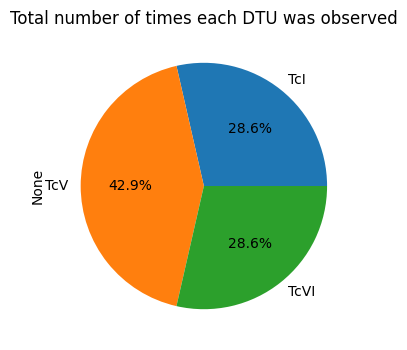

In [9]:
#@title Graphics
ShowGraph = "DTU_distribution" #@param ["DTU_distribution", "Mixed_infections", "Typing", "Heatmap"]
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
adjusted_percentage_output_file = '/content/drive/MyDrive/' + folder + '/Typing_Results/filtered_percentage_table.txt'

# Read in the data from the text file
adjusted_percentage_table = pd.read_csv(adjusted_percentage_output_file, sep='\t', index_col=0)

# Create a table with the total number of times each DTU was observed
DTU_count = (adjusted_percentage_table > 0).sum(axis=1)

# Transpose the table so that we can easily access the DTUs
adjusted_percentage_table = adjusted_percentage_table.T

if ShowGraph=='Typing':
  # Create a stacked horizontal bar chart
  fig, ax = plt.subplots(figsize=(10, 8))
  adjusted_percentage_table.plot(kind='barh', stacked=True, ax=ax)

  # Add titles and labels to the axes
  ax.set_title('Filtered Percentages for each DTU')
  ax.set_xlabel('Percentage')
  ax.set_ylabel('Sample')

  # Add a legend to the chart
  ax.legend(title='DTU', bbox_to_anchor=(1.02, 1), loc='upper left')

  # Save the figure to an image file
  plt.savefig('adjusted_percentage_table.png', dpi=300, bbox_inches='tight')

  # Show the chart

  plt.show()

if ShowGraph=='Mixed_infections':
  # Count the number of samples with more than one DTU
  multi_DTU_samples = (adjusted_percentage_table > 0).sum(axis=1).value_counts()



  # Create a pie chart for the frequency of samples with more than one DTU
  fig, ax = plt.subplots(figsize=(6, 4))
  multi_DTU_samples.plot(kind='pie', ax=ax, autopct='%1.1f%%')



  # Add a title
  ax.set_title('Frequency of samples with more than one DTU')

  # Save the figure to an image file
  plt.savefig('multi_DTU_samples.png', dpi=300, bbox_inches='tight')

  # Show the chart

  plt.show()

if ShowGraph=='DTU_distribution':
  # Create a pie chart for the total number of times each DTU was observed
  fig, ax = plt.subplots(figsize=(6, 4))
  DTU_count.plot(kind='pie', ax=ax, autopct='%1.1f%%')

  # Add a title
  ax.set_title('Total number of times each DTU was observed')


  # Save the figure to an image file
  plt.savefig('DTU_count.png', dpi=300, bbox_inches='tight')


  plt.show()


if ShowGraph=='Heatmap':
  
  # Create a heatmap of the adjusted percentage table
  sns.heatmap(adjusted_percentage_table, cmap='YlGnBu')

  # Add a title
  plt.title('Adjusted Percentages for Each DTU')

  # Save the figure to an image file
  plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

  # Show the chart

  plt.show()



